# 02 - Convex Model: Portfolio Optimization

This notebook builds a convex mean-variance optimizer, tests convexity (Hessian), runs the optimizer for several risk-aversion values, and saves results to the `Results` folder.

In [2]:
# Imports + load processed data
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cvxpy as cp

os.makedirs("Results/plots", exist_ok=True)

mu = pd.read_json("../Results/processed/mean_returns.json", typ="series")
cov = pd.read_csv("../Results/processed/cov_matrix.csv", index_col=0)
tickers = pd.read_csv("../Results/processed/selected_tickers.csv", header=None)[0].tolist()


In [3]:
# Convexity (Hessian PSD check)
Sigma = cov.loc[tickers, tickers].values
H = 2 * Sigma
eigenvalues = np.linalg.eigvalsh(H)  # symmetric eigvals
print("Eigenvalues (min/max):", float(eigenvalues.min()), float(eigenvalues.max()))
print("Is PSD? →", np.all(eigenvalues >= -1e-8))

# Small ridge for numerical stability
Sigma = Sigma + 1e-8 * np.eye(Sigma.shape[0])

Eigenvalues (min/max): 1.0565332164965512e-05 0.06496258867206695
Is PSD? → True


In [4]:
# Solve convex mean-variance problem
n = len(tickers)
x = cp.Variable(n)
lam = 10
objective = cp.Minimize(cp.quad_form(x, Sigma) - lam * (mu.loc[tickers].values @ x))
constraints = [cp.sum(x) == 1, x >= 0, x <= 0.3]
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.OSQP, verbose=False)

weights = x.value
weights[:10]

array([4.35621721e-21, 4.55457459e-21, 4.83129891e-21, 4.49295963e-21,
       4.24907349e-21, 4.41745437e-21, 4.39541395e-21, 4.86050962e-21,
       3.80741435e-21, 4.05728251e-21])

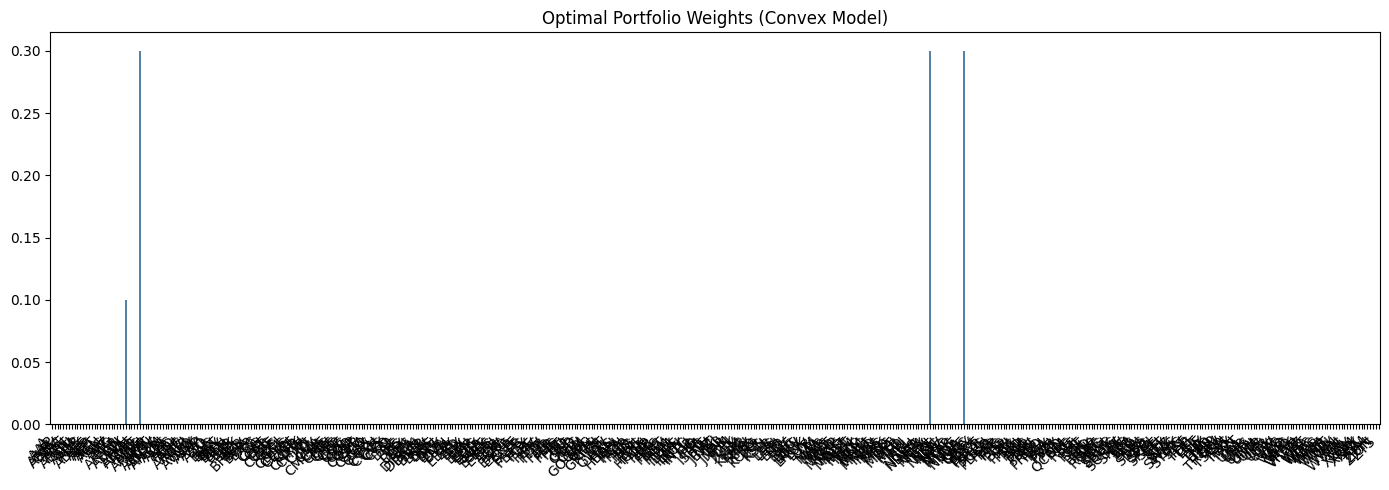

In [5]:
# Allocation plot (saved)
plt.figure(figsize=(14,5))
sns.barplot(x=tickers, y=weights, color="steelblue")
plt.xticks(rotation=45, ha="right")
plt.title("Optimal Portfolio Weights (Convex Model)")
plt.tight_layout()
plt.savefig("../Results/plots/allocation_comparison.png", dpi=150)
plt.show()

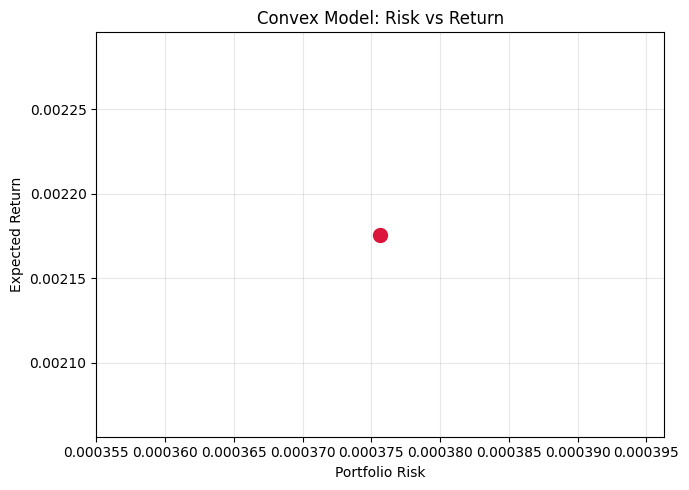

Expected Return: 0.002175911960000019
Risk: 0.00037565265002364133


In [6]:
# Risk vs Return plot (saved)
expected_return = mu.loc[tickers].values @ weights
risk = float(weights.T @ Sigma @ weights)

plt.figure(figsize=(7,5))
plt.scatter(risk, expected_return, s=100, c="crimson")
plt.xlabel("Portfolio Risk")
plt.ylabel("Expected Return")
plt.title("Convex Model: Risk vs Return")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig("../Results/plots/convex_risk_return.png", dpi=150)
plt.show()

print("Expected Return:", float(expected_return))
print("Risk:", risk)